In [101]:
from tensorflow import keras
import tensorflow as tf
# import tensorflow_datasets as tfds
from tensorflow.keras import layers, models
import numpy as np
import matplotlib.pyplot as plt
# import pandas as pd
import os
from PIL import Image
from pathlib import Path
from tensorflow.keras.models import Sequential

In [102]:
image_count = len(list(Path('/Users/khevinjugessur/Documents/ENEL525/Project/pngImages').glob('*/*.png')))
list_ds = tf.data.Dataset.list_files(str("/Users/khevinjugessur/Documents/ENEL525/Project/pngImages/*/*"), shuffle=False)
list_ds = list_ds.shuffle(image_count, reshuffle_each_iteration=False)
print(image_count)
print(len(list_ds))

2100
2100


In [103]:
batch_size = 16
img_height = 180
img_width = 180

class_names = np.array(sorted([item.name for item in Path('/Users/khevinjugessur/Documents/ENEL525/Project/pngImages').iterdir() if item.name != "LICENSE.txt"]))
print(class_names)


['agricultural' 'airplane' 'baseballdiamond' 'beach' 'buildings'
 'chaparral' 'denseresidential' 'forest' 'freeway' 'golfcourse' 'harbor'
 'intersection' 'mediumresidential' 'mobilehomepark' 'overpass'
 'parkinglot' 'river' 'runway' 'sparseresidential' 'storagetanks'
 'tenniscourt']


In [104]:
# val_size = int(image_count * 0.2)
# train_ds = list_ds.skip(val_size)
# val_ds = list_ds.take(val_size)
train_size = int(image_count * 0.7)
val_size = int(image_count * 0.15)
test_size = image_count - train_size - val_size  # rest is for testing

# Split the dataset
train_ds = list_ds.skip(val_size + test_size)  # skip validation and test size
val_ds = list_ds.skip(test_size).take(val_size)  # take the validation size from the remaining
test_ds = list_ds.take(test_size) 

print(tf.data.experimental.cardinality(train_ds).numpy())
print(tf.data.experimental.cardinality(val_ds).numpy())
print(tf.data.experimental.cardinality(test_ds).numpy())

1470
315
315


In [105]:
def get_label(file_path):
  # Convert the path to a list of path components
  parts = tf.strings.split(file_path, os.path.sep)
  # The second to last is the class-directory
  one_hot = parts[-2] == class_names
  # Integer encode the label
  return tf.argmax(one_hot)

def decode_img(img):
  # Convert the compressed string to a 3D uint8 tensor
  img = tf.io.decode_png(img, channels=3)
  # Resize the image to the desired size
  return tf.image.resize(img, [img_height, img_width])

def process_path(file_path):
  label = get_label(file_path)
  # Load the raw data from the file as a string
  img = tf.io.read_file(file_path)
  img = decode_img(img)
  return img, label



In [106]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.map(process_path, num_parallel_calls=AUTOTUNE)

for image, label in train_ds.take(1):
  print("Image shape: ", image.numpy().shape)
  print("Label: ", label.numpy())

Image shape:  (180, 180, 3)
Label:  10


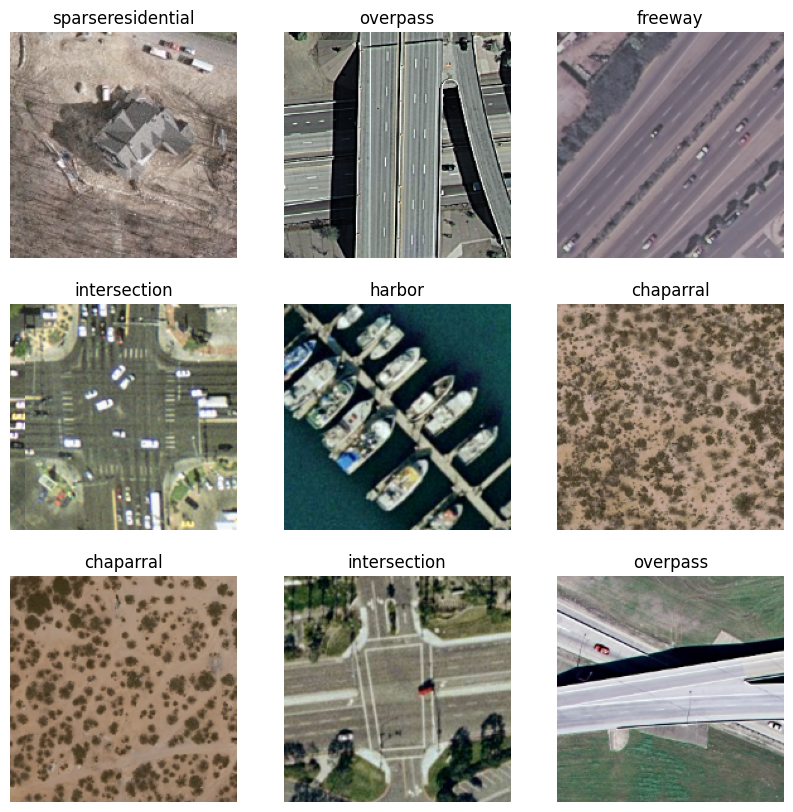

In [107]:
def configure_for_performance(ds):
  ds = ds.cache()
  ds = ds.shuffle(buffer_size=1000)
  ds = ds.batch(batch_size)
  ds = ds.prefetch(buffer_size=AUTOTUNE)
  return ds

train_ds = configure_for_performance(train_ds)
val_ds = configure_for_performance(val_ds)

image_batch, label_batch = next(iter(val_ds))

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].numpy().astype("uint8"))
  label = label_batch[i]
  plt.title(class_names[label])
  plt.axis("off")

In [108]:
num_classes = len(class_names)

# model = Sequential([
#   layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
#   layers.Conv2D(16, 3, padding='same', activation='relu'),
#   layers.MaxPooling2D(),
#   layers.Conv2D(32, 3, padding='same', activation='relu'),
#   layers.MaxPooling2D(),
#   layers.Conv2D(64, 3, padding='same', activation='relu'),
#   layers.MaxPooling2D(),
#   layers.Flatten(),
#   layers.Dense(128, activation='relu'),
#   layers.Dense(num_classes)
# ])

In [109]:
# model.compile(optimizer='adam',
#               loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
#               metrics=['accuracy'])

In [110]:
# model.summary()

In [111]:
# epochs=10
# history = model.fit(
#   train_ds,
#   validation_data=val_ds,
#   epochs=epochs
# )

In [112]:
# acc = history.history['accuracy']
# val_acc = history.history['val_accuracy']

# loss = history.history['loss']
# val_loss = history.history['val_loss']

# epochs_range = range(epochs)

# plt.figure(figsize=(8, 8))
# plt.subplot(1, 2, 1)
# plt.plot(epochs_range, acc, label='Training Accuracy')
# plt.plot(epochs_range, val_acc, label='Validation Accuracy')
# plt.legend(loc='lower right')
# plt.title('Training and Validation Accuracy')

# plt.subplot(1, 2, 2)
# plt.plot(epochs_range, loss, label='Training Loss')
# plt.plot(epochs_range, val_loss, label='Validation Loss')
# plt.legend(loc='upper right')
# plt.title('Training and Validation Loss')
# plt.show()

In [113]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2024-12-17 21:15:57.242787: W tensorflow/core/kernels/data/cache_dataset_ops.cc:914] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


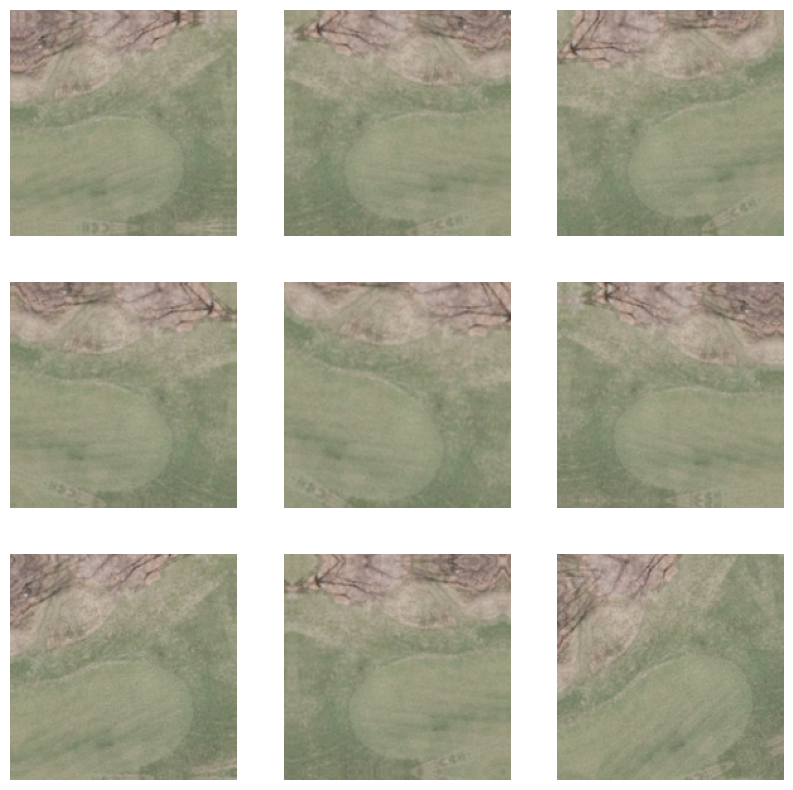

In [114]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [115]:

model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(96, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.4),#0.2
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dropout(0.4),
  layers.Dense(num_classes, name="outputs")
])

In [116]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.summary()

Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_9 (Sequential)       │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_5 (Rescaling)         │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 180, 180, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_15 (MaxPooling2D) │ (None, 90, 90, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 90, 90, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_16 (MaxPooling2D) │ (None, 45, 45, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 45, 45, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_17 (MaxPooling2D) │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_18 (Conv2D)              │ (None, 22, 22, 96)     │        55,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_18 (MaxPooling2D) │ (None, 11, 11, 96)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 11, 11, 96)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 11616)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │     1,486,976 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ outputs (Dense)                 │ (None, 21)             │         2,709 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,568,661 (5.98 MB)

 Trainable params: 1,568,661 (5.98 MB)

 Non-trainable params: 0 (0.00 B)

In [117]:
epochs = 100
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 41s 424ms/step - accuracy: 0.0548 - loss: 3.0287 - val_accuracy: 0.1111 - val_loss: 2.8249
Epoch 2/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 26s 286ms/step - accuracy: 0.1191 - loss: 2.8338 - val_accuracy: 0.1937 - val_loss: 2.7095
Epoch 3/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 32s 345ms/step - accuracy: 0.1410 - loss: 2.6070 - val_accuracy: 0.2476 - val_loss: 2.4362
Epoch 4/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 27s 295ms/step - accuracy: 0.2055 - loss: 2.4597 - val_accuracy: 0.3206 - val_loss: 2.2237
Epoch 5/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 27s 293ms/step - accuracy: 0.2922 - loss: 2.2067 - val_accuracy: 0.4254 - val_loss: 2.1026
Epoch 6/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 25s 275ms/step - accuracy: 0.3101 - loss: 2.0324 - val_accuracy: 0.4540 - val_loss: 1.8169
Epoch 7/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 25s 266ms/step - accuracy: 0.3449 - loss: 1.9457 - val_accuracy: 0.4381 - val_loss: 1.8666
Epoch 8/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 23s 246ms/step - accuracy: 0.4156 - loss: 1.7883 - 

In [118]:


# history =model.fit(
#   train_ds,
#   validation_data=val_ds,
#   epochs=100,
#   initial_epoch=epochs
# )
# epochs = 100


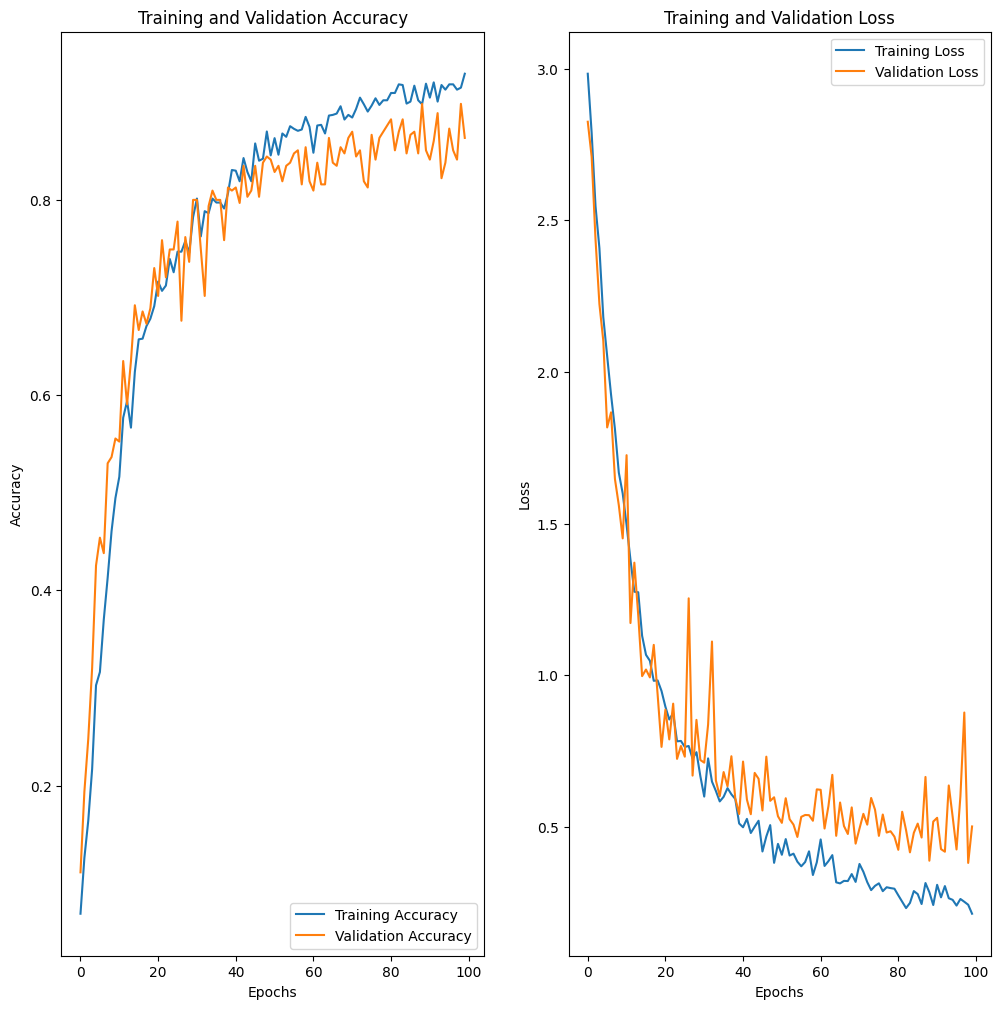

In [127]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(12, 12))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [120]:


def test_configure_for_performance(ds):
  ds = ds.cache()
  ds = ds.batch(batch_size)
  ds = ds.prefetch(buffer_size=AUTOTUNE)
  return ds
test_ds = list_ds.take(test_size) 
test_ds = test_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_configure_for_performance(test_ds)
test_loss, test_accuracy = model.evaluate(test_ds)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 75ms/step - accuracy: 0.8524 - loss: 0.5666
Test Loss: 0.6735299229621887
Test Accuracy: 0.8285714387893677


In [121]:
tf.keras.utils.plot_model(model, show_shapes=True)

You must install graphviz (see instructions at https://graphviz.gitlab.io/download/) for `plot_model` to work.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


2024-12-17 22:42:30.312790: W tensorflow/core/kernels/data/cache_dataset_ops.cc:914] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


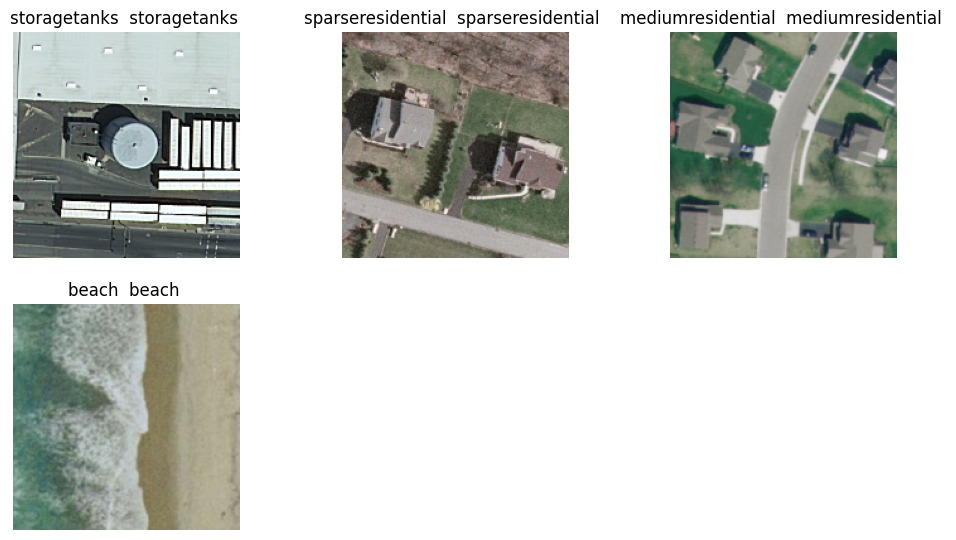

In [125]:
test_ds = list_ds.take(test_size) 
test_ds = test_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_configure_for_performance(test_ds)

image_batch, label_batch = next(iter(test_ds))
plt.figure(figsize=(12, 10))
for i in range(4):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].numpy().astype("uint8"))
  label = label_batch[i]
  predictions = model.predict(tf.expand_dims(image_batch[i].numpy(), axis=0) )
  score = tf.nn.softmax(predictions[0])
  plt.title(f"{class_names[label]}  {class_names[tf.argmax(score).numpy()]} ")
  plt.axis("off")